In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/'CV Project'/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CV Project
BasicCNNwithBatchNorm_Detection    ELA_extracted_X.npy	tmp_img.jpg
CASIA2.0_revised		   ELA_extracted_y.npy	tp_X.npy
CASIA2_feature_DCT_LBP.csv	   Masking_Basic.h5	tp_Y.npy
CASIA2_feature_DCT_LBP_labels.csv  ResNetCNN_Detection


In [5]:
import os
import numpy as np
import cv2
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
def get_ela(dir, filename):
    path = os.path.join(dir, filename)
    temp_img = 'tmp_img_bw.jpg'

    image = Image.open(path)
    filtered_image = image.convert('RGB').filter(ImageFilter.BoxBlur(0.5))
    filtered_image.save(temp_img, 'JPEG', quality = 90)
    
    temp_image = Image.open(temp_img)
    
    ela_image = ImageChops.difference(filtered_image, temp_image)
    
    extremas = ela_image.getextrema()
    max_ext = max([x[1] for x in extremas])
    if max_ext == 0:
        scale = 255.0
    else:
        scale = 255.0 / max_ext
    
    ela_image = ImageEnhance.Brightness(ela_image)
    ela_image = ela_image.enhance(scale)

    result = np.array(ela_image.resize((128,128))).flatten()/255

    return result

In [6]:
au_path = "CASIA2.0_revised/Au"
au_mask_path = "CASIA2.0_revised/Au_mask"

tp_path = "CASIA2.0_revised/Tp"
tp_mask_path = "CASIA2.0_revised/Tp_mask"

img_height = 128
img_width = 128

tp_ids = os.listdir(tp_path)
X = np.zeros((len(tp_ids), img_height, img_width, 3), dtype=np.float32)
X_ELA = np.zeros((len(tp_ids), img_height, img_width, 3), dtype=np.float32)
y = np.zeros((len(tp_ids), img_height, img_width, 1), dtype=np.float32)

for i, file_name in tqdm.tqdm_notebook(enumerate(tp_ids), total=len(tp_ids)):
    img_path = tp_path + "/" + file_name
    image = load_img(img_path)
    img_array = resize(img_to_array(image), (img_height, img_width, 3), mode = 'constant', preserve_range=True)
    file_name, ext = os.path.splitext(file_name)

    gt_img_path = tp_mask_path + "/" + file_name + "_gt" + '.png'
    gt_image = load_img(gt_img_path, color_mode = "grayscale")
    img_mask_array = resize(img_to_array(gt_image), (img_height, img_width, 1), mode = 'constant', preserve_range=True)

    X[i] = img_array.squeeze() / 255
    X_ELA[i] = get_image_with_ela(tp_path, file_name)
    y[i] = img_mask_array / 255

print(X.shape)
print(X_ELA.shape)
print(y.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5123 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7492 [00:00<?, ?it/s]

FileNotFoundError: ignored

In [8]:
for n, name in tqdm.tqdm_notebook(enumerate(ids), total=len(ids)):
  try:
    img_path = au_path + "/" + name
    img = img_to_array(load_img(img_path, color_mode = "grayscale"))
    img_array = resize(img, (img_height, img_width, 1), mode = 'constant', preserve_range=True)
    name, ext = os.path.splitext(name)
    img_mask = img_to_array(load_img(au_mask_path + "/" + name + "_gt" + ext, color_mode = "grayscale"))
    img_mask_array = resize(img_mask, (img_height, img_width, 1), mode = 'constant', preserve_range=True)
    X2[n, ..., 0] = img_array.squeeze() / 255
    y2[n] = img_mask_array / 255
  except:
    continue

X = np.vstack([X, X2])
y = np.vstack([y, y2])
print(X.shape)
print(y.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/7492 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


(12615, 128, 128, 1)
(12615, 128, 128, 1)


In [9]:
with open('tp_X_all.npy', 'wb') as f:
    np.save(f, X)
with open('tp_Y_all.npy', 'wb') as f:
    np.save(f, y)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)

In [11]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [12]:
def MyConv(num_filters, num_kernel_size=3):
  conv = Conv2D(
      filters=num_filters,
      kernel_size=num_kernel_size,
      activation='relu',
      kernel_initializer="he_normal",
      padding="same"
  )
  return conv

input_size = (128, 128, 1)
inputs = Input(input_size)
conv1 = MyConv(64, 3)(inputs)
conv1 = MyConv(64, 3)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = MyConv(128, 3)(pool1)
conv2 = MyConv(128, 3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = MyConv(256, 3)(pool2)
conv3 = MyConv(256, 3)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = MyConv(512, 3)(pool3)
conv4 = MyConv(512, 3)(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = MyConv(1024, 3)(pool4)
conv5 = MyConv(1024, 3)(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = MyConv(512, 2)(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = MyConv(512, 3)(merge6)
conv6 = MyConv(512, 3)(conv6)

up7 = MyConv(256, 2)(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = MyConv(256, 3)(merge7)
conv7 = MyConv(256, 3)(conv7)

up8 = MyConv(128, 2)(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = MyConv(128, 3)(merge8)
conv8 = MyConv(128, 3)(conv8)

up9 = MyConv(64, 2)(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = MyConv(64, 3)(merge9)
conv9 = MyConv(64, 3)(conv9)
conv9 = MyConv(2, 3)(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

model_checkpoint = ModelCheckpoint('Masking_Basic_All.h5', verbose=1, save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, mode='min')
early_stopping = EarlyStopping(patience=10, verbose=1)

In [14]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [15]:
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

batch_size = 32
epochs = 50

image_generator = image_datagen.flow(X_train, batch_size=batch_size, shuffle=True)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, shuffle=True)

train_generator = zip(image_generator, mask_generator)

results = model.fit_generator(train_generator, steps_per_epoch=(len(X_train) // batch_size), epochs=epochs, callbacks=[model_checkpoint, early_stopping],
                              validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/50
335/335 [==============================] - ETA: 0s - loss: 43.0082 - accuracy: 0.9587
Epoch 00001: val_loss improved from inf to 0.17425, saving model to Masking_Basic_All.h5
335/335 [==============================] - 110s 280ms/step - loss: 43.0082 - accuracy: 0.9587 - val_loss: 0.1742 - val_accuracy: 0.9544
Epoch 2/50
335/335 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9586
Epoch 00002: val_loss improved from 0.17425 to 0.16783, saving model to Masking_Basic_All.h5
335/335 [==============================] - 93s 277ms/step - loss: 0.1584 - accuracy: 0.9586 - val_loss: 0.1678 - val_accuracy: 0.9544
Epoch 3/50
335/335 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9587
Epoch 00003: val_loss did not improve from 0.16783
335/335 [==============================] - 91s 273ms/step - loss: 0.1559 - accuracy: 0.9587 - val_loss: 0.1706 - val_accuracy: 0.9544
Epoch 4/50
335/335 [==============================] - ETA: 0s - loss: 0.15

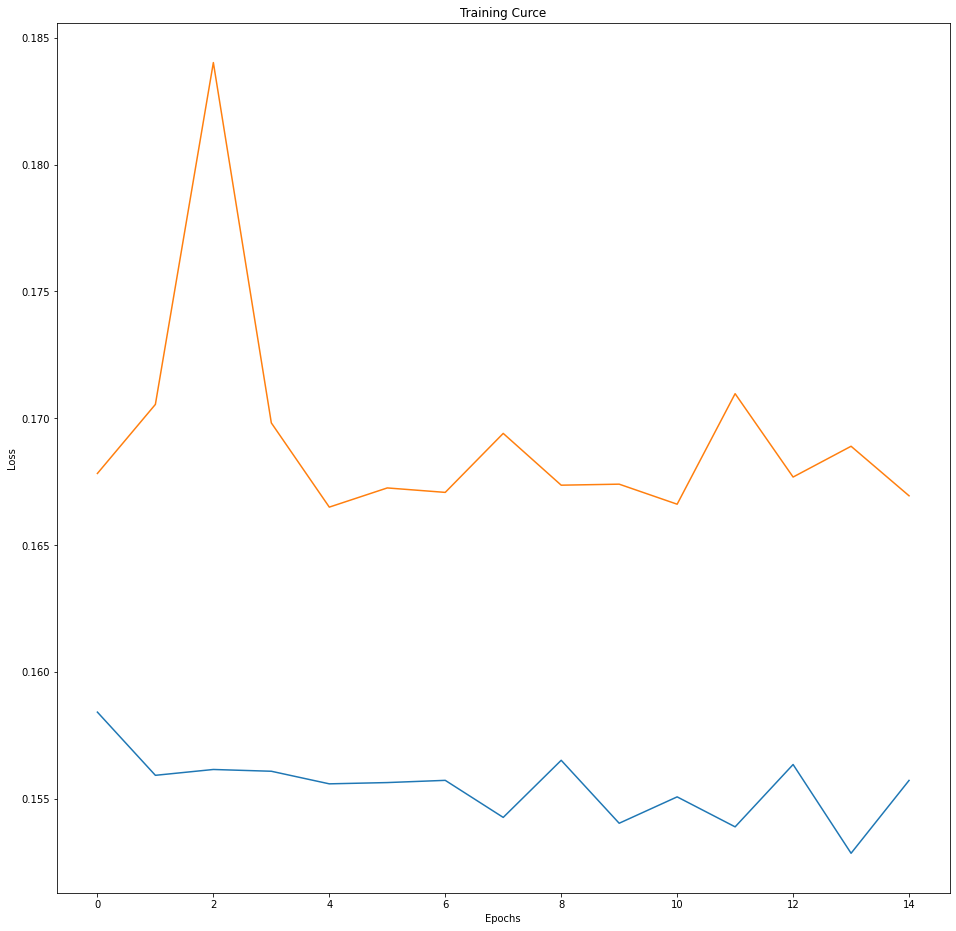

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Training Curve")
plt.plot(results.history["loss"][1:], label="Train Loss")
plt.plot(results.history["val_loss"][1:], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [17]:
P_train = model.predict(X_train, verbose=1)
P_val = model.predict(X_valid, verbose=1)

60/60 [==============================] - 4s 75ms/step


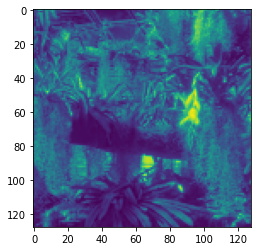

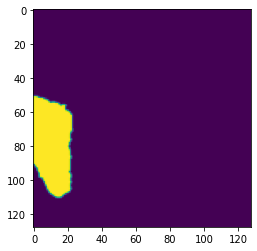

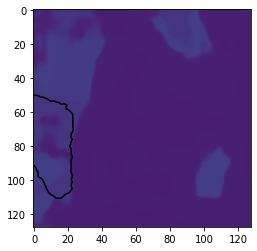

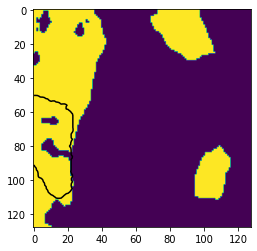

In [99]:
id = 1
plt.imshow(X[id, ..., 0])
plt.show()
plt.imshow(y[id].squeeze())
plt.show()
plt.imshow(P_train[id].squeeze(), vmin=0, vmax=1)
plt.contour(y[id].squeeze(), colors='k', levels=[0.2])
plt.show()
plt.imshow(P_train_t[id].squeeze(), vmin=0, vmax=1)
plt.contour(y[id].squeeze(), colors='k', levels=[0.2])
plt.show()

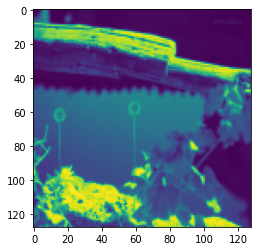

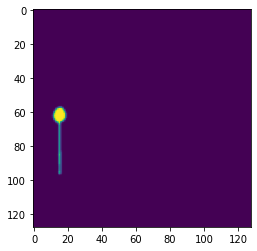

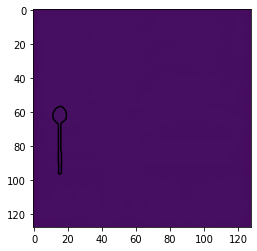

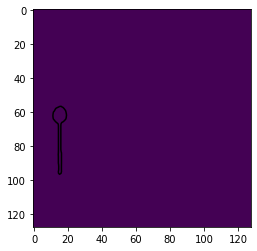

In [29]:
id = 9
# fig, ax = plt.subplots(1, 4, figsize=(20, 10))
plt.imshow(X[id, ..., 0])
plt.show()
plt.imshow(y[id].squeeze())
plt.show()
plt.imshow(P_train[id].squeeze(), vmin=0, vmax=1)
# plt.imshow(im_bw, vmin=0, vmax=1)
plt.contour(y[id].squeeze(), colors='k', levels=[0.2])
plt.show()
plt.imshow(P_train_t[id].squeeze(), vmin=0, vmax=1)
plt.contour(y[id].squeeze(), colors='k', levels=[0.2])
plt.show()